# Grab Repository data      

In [1]:
from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [2]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/pull_requests_time_to_close_per_{BUCKET_SIZE}_days.csv'

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P9', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P2', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P8', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P1', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/5x4imrvk5b', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P7', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P14', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P6', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/bznd2hh7ii', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person

In [3]:
if INTRO_DATE == "":
    import json
    mapping_file = f"{repository_directories[0]}/mapping.json"
    # Check if the file exists
    if not os.path.exists(mapping_file):
        print(f"File not found: {mapping_file}. ")
    with open(mapping_file, 'r') as f:
        mapping = json.load(f)
    print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")

START_DATE = None
END_DATE = None


Using INTRO_DATE from mapping file: 


# Generate PR Metrics per Repository

## Time to close Pull requests

In [4]:
def parse_duration(duration_str):
    try:
        days, hours, minutes, seconds = map(int, duration_str.split(":"))
        return pd.Timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    except:
        return pd.NaT  # handle invalid formats


In [5]:
pr_result = []
import numpy as np
for repository in repositories:
    if INTRO_DATE == "":
        person = repository.split('/')[-1]
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    pr_file = f"{repository}/pull_requests.csv"
    # Check if the file exists
    if not os.path.exists(pr_file) or os.stat(pr_file).st_size == 1:
        print(f"File not found or empty: {pr_file}. Skipping repository.")
        continue
    pr_df = pd.read_csv(pr_file)

    pr_df = truncate_to_same_length(pr_df, INTRO_DATE, 'created_at', 'defined', START_DATE, END_DATE)

    # pr_df = aggregate_by_date(pr_df, 'created_at', 'time_until_merged', 'sum')

    print(pr_df['created_at'].max())
    pr_df['time_until_closed_OG'] = pr_df['time_until_closed']
    # Apply to the column
    pr_df['time_until_closed'] = pr_df['time_until_closed'].apply(parse_duration)
    # Immediately convert it to float days
    pr_df['time_until_closed'] = pr_df['time_until_closed'].apply(
        lambda td: td.total_seconds() / (3600 * 24) if pd.notna(td) else np.nan
    )

    print(pr_df.head())

    
    pre_release, post_release = split_by_date(pr_df, INTRO_DATE, 'created_at')

    pre_release_buckets = generate_value_in_buckets(pre_release, 'created_at', 'time_until_closed', 'mean', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'created_at', 'time_until_closed', 'mean', BUCKET_SIZE, 'post-')

    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]

    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')['time_until_closed'].to_dict())  # Use 'count' instead of 'value'
    
    pr_result.append(result_row)

# Create the DataFrame
pr_result_df = pd.DataFrame(pr_result)

pr_result_df


2025-02-14 14:14:51.338000+00:00
   merge_id                                       sha      author  merged_by  \
1        55  74f90ec57250b58ee5ed5744a8311f7306fd8699  P3        NaN   
3        54  a09f277fc1997d655fcf17c6a8b66f7f8622e9e1  P3        NaN   
4        53  17c26445e26c92441ba9bb83c994945f45f08ff1  P3        NaN   
5        52  b07cd20b684546bffb69839592b16cf82c0c334e  bznd2hh7ii        NaN   
6        51  4e67a1cbc9e338e7e644bfb638aaa396f69cf94b  P3        NaN   

                    merged_at   state                       created_at  \
1  2025-03-13T14:31:03.886000  MERGED 2025-02-12 10:47:10.018000+00:00   
3  2025-02-10T10:28:38.232000  MERGED 2025-02-07 14:16:10.162000+00:00   
4  2025-02-05T12:28:04.347000  MERGED 2025-02-05 12:27:07.819000+00:00   
5  2024-11-15T09:09:22.762000  MERGED 2024-11-14 15:05:57.118000+00:00   
6  2024-09-16T11:15:20.810000  MERGED 2024-09-11 11:46:08.673000+00:00   

                   updated_at                   closed_at  \
1  2025-03-1

/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_66587/3998517624.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)


,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,6.371463,2.642677,1.785363,3.090523,5.698543,3.348368,3.616164,3.809641,3.154489,4.274836,6.312137,1.699060,8.861547,5.448346,NaN,8.348713,3.107306,4.140583
1,P9,0.669967,0.833621,1.079917,0.673713,1.734561,0.201310,0.630355,3.937755,0.876212,1.340155,8.076593,1.536465,0.342594,2.798989,2.384428,1.101015,NaN,1.015454
2,P2,2.835417,NaN,2.985327,3.331736,8.231096,1.335963,NaN,0.684949,NaN,4.106005,3.214150,4.424606,2.530651,2.717086,2.997818,1.778710,3.382674,3.577341
3,P8,0.800557,1.046712,2.797458,2.630781,1.361000,1.381300,2.463537,1.991658,1.646767,2.204495,3.271091,1.131748,1.417918,1.932731,NaN,2.737729,1.907109,1.761932
4,P1,1.576633,1.040199,0.640623,0.984130,0.708667,0.493763,0.922520,1.191407,0.593164,0.732955,1.704208,4.579775,0.988599,28.108819,1.571726,0.842692,1.236919,1.634934
5,k1bu0cscd4,40.022315,NaN,0.014873,0.000810,NaN,14.108681,NaN,NaN,NaN,3.526389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,0.872560,0.929464,1.412832,0.706611,1.579890,0.149293,1.221402,1.675669,1.462449,0.468557,2.820632,1.852130,0.345207,16.279516,4.023073,0.686367,0.834407,2.805036
7,P7,2.546797,0.439751,0.463102,0.334453,1.530061,0.150285,0.688458,0.712245,NaN,1.960239,0.726551,2.504429,0.734436,1.042663,NaN,0.019609,0.490176,0.993927
8,P5,0.838254,8.235598,4.440460,NaN,3.129076,2.528536,NaN,NaN,NaN,2.109464,3.021570,4.023573,1.864211,14.143414,NaN,0.503432,2.552047,3.903092
9,P14,3.113290,0.910568,0.386672,0.991007,1.200066,0.125192,1.229447,1.624879,0.093123,1.906608,2.066819,2.155775,4.721755,5.041753,3.063176,1.922656,1.443302,0.569012


In [6]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(pr_result_df, 'pre-', 'post-')
pr_result_df = pr_result_df[columns_order]

In [7]:
pr_result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,6.371463,2.642677,1.785363,3.090523,5.698543,3.348368,3.616164,3.809641,3.154489,4.274836,6.312137,1.699060,8.861547,5.448346,NaN,8.348713,3.107306,4.140583
1,P9,0.669967,0.833621,1.079917,0.673713,1.734561,0.201310,0.630355,3.937755,0.876212,1.340155,8.076593,1.536465,0.342594,2.798989,2.384428,1.101015,NaN,1.015454
2,P2,2.835417,NaN,2.985327,3.331736,8.231096,1.335963,NaN,0.684949,NaN,4.106005,3.214150,4.424606,2.530651,2.717086,2.997818,1.778710,3.382674,3.577341
3,P8,0.800557,1.046712,2.797458,2.630781,1.361000,1.381300,2.463537,1.991658,1.646767,2.204495,3.271091,1.131748,1.417918,1.932731,NaN,2.737729,1.907109,1.761932
4,P1,1.576633,1.040199,0.640623,0.984130,0.708667,0.493763,0.922520,1.191407,0.593164,0.732955,1.704208,4.579775,0.988599,28.108819,1.571726,0.842692,1.236919,1.634934
5,k1bu0cscd4,40.022315,NaN,0.014873,0.000810,NaN,14.108681,NaN,NaN,NaN,3.526389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,0.872560,0.929464,1.412832,0.706611,1.579890,0.149293,1.221402,1.675669,1.462449,0.468557,2.820632,1.852130,0.345207,16.279516,4.023073,0.686367,0.834407,2.805036
7,P7,2.546797,0.439751,0.463102,0.334453,1.530061,0.150285,0.688458,0.712245,NaN,1.960239,0.726551,2.504429,0.734436,1.042663,NaN,0.019609,0.490176,0.993927
8,P5,0.838254,8.235598,4.440460,NaN,3.129076,2.528536,NaN,NaN,NaN,2.109464,3.021570,4.023573,1.864211,14.143414,NaN,0.503432,2.552047,3.903092
9,P14,3.113290,0.910568,0.386672,0.991007,1.200066,0.125192,1.229447,1.624879,0.093123,1.906608,2.066819,2.155775,4.721755,5.041753,3.063176,1.922656,1.443302,0.569012


In [8]:
# for col in pr_result_df.columns[1:]:  # Skip 'repository'
#     pr_result_df[col] = pd.to_timedelta(pr_result_df[col], errors='coerce')


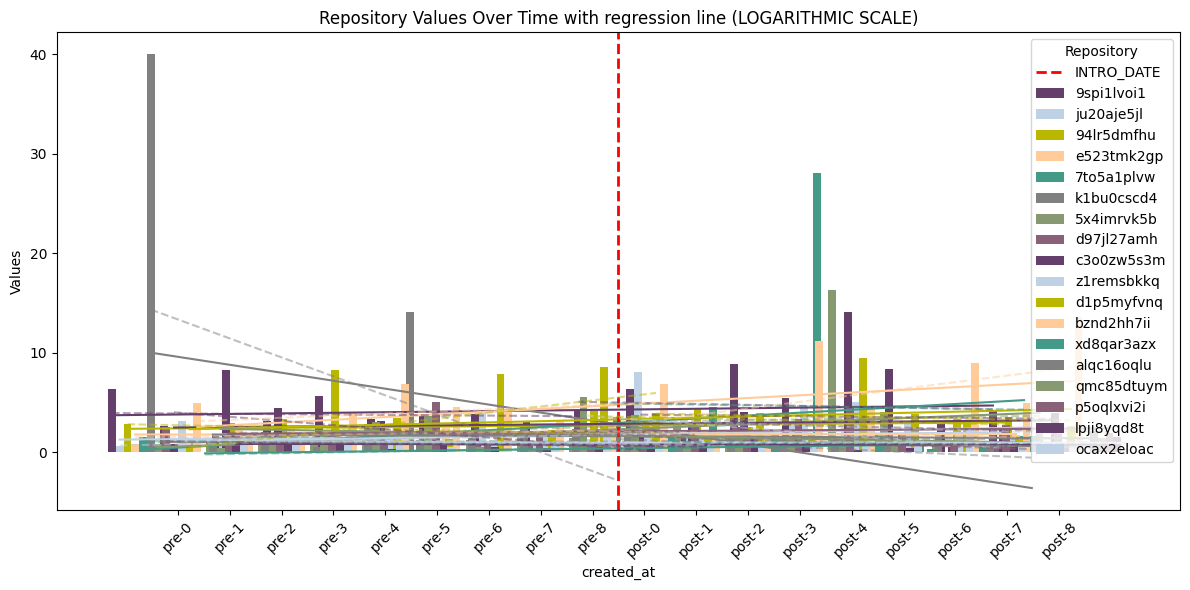

In [9]:
import numpy as np
from scipy.stats import linregress

tangent_data = []

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in pr_result_df.columns if col != 'repository']
colors = ["#FF4500", "#FFA500", "#FF8C00", "#FFD700", "#FF6347", "#FF7F50", "#FFB347", "#FFCC99"]
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#FFCC99", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(pr_result_df['repository']):
    # Extract data for the current repository
    values = pr_result_df[pr_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    m, b, _, _, _ = linregress(x, values.values)
    regression_line = m * x + b
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='-', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = pr_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))
    post_0 = 'post-0' if 'post-0' in post_columns else None
    
    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2

        # Vertical red line at midpoint
        plt.axvline(x=midpoint + (len(pr_result_df['repository']) - 1) * bar_width / 2,
                    color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Plot bars and regression lines
for i, repo in enumerate(pr_result_df['repository']):
    values = pr_result_df[pr_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)

    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, bar_width, label="_nolegend_", color=colors[i % len(colors)])

    if pre_columns and post_columns and largest_pre and post_0:
        # Indices for regression segments
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Extract values
        pre_values = values.values[pre_range]
        post_values = values.values[post_range]

        # Regression before midpoint
        m_pre, b_pre, *_ = linregress(pre_range, pre_values)
        reg_line_pre = m_pre * pre_range + b_pre
        plt.plot(offset_x[pre_range], reg_line_pre, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Regression after midpoint
        m_post, b_post, *_ = linregress(post_range, post_values)
        reg_line_post = m_post * post_range + b_post
        plt.plot(offset_x[post_range], reg_line_post, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Collect regression parameters
        tangent_data.append({
            'repository': repo,
            'm_pre': m_pre,
            'b_pre': b_pre,
            'm_post': m_post,
            'b_post': b_post
        })




# Set x-axis ticks and labels
plt.xticks(x + (len(pr_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
# plt.yscale('log')
plt.show()

In [10]:
tangent_df = pd.DataFrame(tangent_data)
print(tangent_df)


    repository     m_pre      b_pre    m_post    b_post
0   P3 -0.035993   3.941174 -0.095229  5.926038
1   P9  0.114883   0.680783 -0.405961  7.343679
2   P2 -0.102769   2.813511 -0.107229  4.586087
3   P8  0.074699   1.496279 -0.067803  2.699739
4   P1 -0.050716   1.116628 -0.078083  5.615151
5   k1bu0cscd4 -1.905645  14.342710 -0.235093  3.448025
6   5x4imrvk5b  0.009229   1.006341  0.078893  2.320494
7   P7 -0.045026   1.085157 -0.171307  3.168334
8   P5 -0.418249   4.010261 -0.052309  4.248998
9   P14 -0.065156   1.451288 -0.155763  4.568343
10  P6  0.609975   0.464107 -0.086240  4.647814
11  bznd2hh7ii  0.213023   3.115405  0.660030 -2.611222
12  xd8qar3azx  0.084777  -0.226072 -0.063211  1.663451
13  P4  0.065701   1.435641 -0.005298  1.411110
14  P13  0.155956   1.413942 -0.129140  2.601537
15  P12 -0.022116   1.952297 -0.116385  3.986130
16  P10 -0.046909   0.990722  0.000408  0.817280
17  P11 -0.043367   1.148038 -0.003332  1.013798


# Significancetest 

In [11]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(pr_result_df.head())

# Columns for pre and after buckets
pre_columns = [col for col in pr_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in pr_result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(pr_result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

   repository     pre-0     pre-1     pre-2     pre-3     pre-4     pre-5  \
0  P3  6.371463  2.642677  1.785363  3.090523  5.698543  3.348368   
1  P9  0.669967  0.833621  1.079917  0.673713  1.734561  0.201310   
2  P2  2.835417       NaN  2.985327  3.331736  8.231096  1.335963   
3  P8  0.800557  1.046712  2.797458  2.630781  1.361000  1.381300   
4  P1  1.576633  1.040199  0.640623  0.984130  0.708667  0.493763   

      pre-6     pre-7     pre-8    post-0    post-1    post-2    post-3  \
0  3.616164  3.809641  3.154489  4.274836  6.312137  1.699060  8.861547   
1  0.630355  3.937755  0.876212  1.340155  8.076593  1.536465  0.342594   
2       NaN  0.684949       NaN  4.106005  3.214150  4.424606  2.530651   
3  2.463537  1.991658  1.646767  2.204495  3.271091  1.131748  1.417918   
4  0.922520  1.191407  0.593164  0.732955  1.704208  4.579775  0.988599   

      post-4    post-5    post-6    post-7    post-8  
0   5.448346       NaN  8.348713  3.107306  4.140583  
1   2.798989  2.

/Users/annemariewittig/Master/repo-analysis/metricScripts/helper/significance.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  after_stat, after_p = shapiro(after_values)
/Users/annemariewittig/Master/repo-analysis/metricScripts/helper/significance.py:23: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  pre_stat, pre_p = shapiro(pre_values)


In [12]:
# significance_results_df = use_normality_results_for_significance_independent(normality_results, pr_result_df, pre_columns, after_columns)

# # Display the results
# print(significance_results_df)
from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(pr_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

    repository      test_used  effect_size  ci_lower  ci_upper
0   P3  Cliff's Delta     0.345679 -0.160802  0.802469
1   P9  Cliff's Delta     0.419753 -0.111111  0.864198
2   P2  Cliff's Delta     0.172840 -0.234568  0.567901
3   P8  Cliff's Delta     0.197531 -0.296296  0.703704
4   P1  Cliff's Delta     0.629630  0.160494  0.950617
5   k1bu0cscd4  Cliff's Delta     0.000000 -0.074074  0.074074
6   5x4imrvk5b  Cliff's Delta     0.234568 -0.333333  0.802469
7   P7  Cliff's Delta     0.246914 -0.209877  0.704321
8   P5  Cliff's Delta    -0.074074 -0.420062  0.296296
9   P14  Cliff's Delta     0.679012  0.209877  1.000000
10  P6  Cliff's Delta     0.283951 -0.283951  0.827160
11  bznd2hh7ii  Cliff's Delta     0.419753 -0.037037  0.851852
12  xd8qar3azx  Cliff's Delta     0.000000  0.000000  0.000000
13  P4  Cliff's Delta    -0.358025 -0.802469  0.185185
14  P13  Cliff's Delta    -0.234568 -0.666667  0.271914
15  P12  Cliff's Delta     0.580247  0.061728  0.975309
16  P10  Cliff's Delta

In [13]:
merged = pr_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,6.371463,2.642677,1.785363,3.090523,5.698543,3.348368,3.616164,3.809641,3.154489,...,8.861547,5.448346,NaN,8.348713,3.107306,4.140583,Cliff's Delta,0.345679,-0.160802,0.802469
1,P9,0.669967,0.833621,1.079917,0.673713,1.734561,0.201310,0.630355,3.937755,0.876212,...,0.342594,2.798989,2.384428,1.101015,NaN,1.015454,Cliff's Delta,0.419753,-0.111111,0.864198
2,P2,2.835417,NaN,2.985327,3.331736,8.231096,1.335963,NaN,0.684949,NaN,...,2.530651,2.717086,2.997818,1.778710,3.382674,3.577341,Cliff's Delta,0.172840,-0.234568,0.567901
3,P8,0.800557,1.046712,2.797458,2.630781,1.361000,1.381300,2.463537,1.991658,1.646767,...,1.417918,1.932731,NaN,2.737729,1.907109,1.761932,Cliff's Delta,0.197531,-0.296296,0.703704
4,P1,1.576633,1.040199,0.640623,0.984130,0.708667,0.493763,0.922520,1.191407,0.593164,...,0.988599,28.108819,1.571726,0.842692,1.236919,1.634934,Cliff's Delta,0.629630,0.160494,0.950617
5,k1bu0cscd4,40.022315,NaN,0.014873,0.000810,NaN,14.108681,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,-0.074074,0.074074
6,5x4imrvk5b,0.872560,0.929464,1.412832,0.706611,1.579890,0.149293,1.221402,1.675669,1.462449,...,0.345207,16.279516,4.023073,0.686367,0.834407,2.805036,Cliff's Delta,0.234568,-0.333333,0.802469
7,P7,2.546797,0.439751,0.463102,0.334453,1.530061,0.150285,0.688458,0.712245,NaN,...,0.734436,1.042663,NaN,0.019609,0.490176,0.993927,Cliff's Delta,0.246914,-0.209877,0.704321
8,P5,0.838254,8.235598,4.440460,NaN,3.129076,2.528536,NaN,NaN,NaN,...,1.864211,14.143414,NaN,0.503432,2.552047,3.903092,Cliff's Delta,-0.074074,-0.420062,0.296296
9,P14,3.113290,0.910568,0.386672,0.991007,1.200066,0.125192,1.229447,1.624879,0.093123,...,4.721755,5.041753,3.063176,1.922656,1.443302,0.569012,Cliff's Delta,0.679012,0.209877,1.000000


In [14]:
merged = pr_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,6.371463,2.642677,1.785363,3.090523,5.698543,3.348368,3.616164,3.809641,3.154489,...,8.861547,5.448346,NaN,8.348713,3.107306,4.140583,Cliff's Delta,0.345679,-0.160802,0.802469
1,P9,0.669967,0.833621,1.079917,0.673713,1.734561,0.201310,0.630355,3.937755,0.876212,...,0.342594,2.798989,2.384428,1.101015,NaN,1.015454,Cliff's Delta,0.419753,-0.111111,0.864198
2,P2,2.835417,NaN,2.985327,3.331736,8.231096,1.335963,NaN,0.684949,NaN,...,2.530651,2.717086,2.997818,1.778710,3.382674,3.577341,Cliff's Delta,0.172840,-0.234568,0.567901
3,P8,0.800557,1.046712,2.797458,2.630781,1.361000,1.381300,2.463537,1.991658,1.646767,...,1.417918,1.932731,NaN,2.737729,1.907109,1.761932,Cliff's Delta,0.197531,-0.296296,0.703704
4,P1,1.576633,1.040199,0.640623,0.984130,0.708667,0.493763,0.922520,1.191407,0.593164,...,0.988599,28.108819,1.571726,0.842692,1.236919,1.634934,Cliff's Delta,0.629630,0.160494,0.950617
5,k1bu0cscd4,40.022315,NaN,0.014873,0.000810,NaN,14.108681,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,-0.074074,0.074074
6,5x4imrvk5b,0.872560,0.929464,1.412832,0.706611,1.579890,0.149293,1.221402,1.675669,1.462449,...,0.345207,16.279516,4.023073,0.686367,0.834407,2.805036,Cliff's Delta,0.234568,-0.333333,0.802469
7,P7,2.546797,0.439751,0.463102,0.334453,1.530061,0.150285,0.688458,0.712245,NaN,...,0.734436,1.042663,NaN,0.019609,0.490176,0.993927,Cliff's Delta,0.246914,-0.209877,0.704321
8,P5,0.838254,8.235598,4.440460,NaN,3.129076,2.528536,NaN,NaN,NaN,...,1.864211,14.143414,NaN,0.503432,2.552047,3.903092,Cliff's Delta,-0.074074,-0.420062,0.296296
9,P14,3.113290,0.910568,0.386672,0.991007,1.200066,0.125192,1.229447,1.624879,0.093123,...,4.721755,5.041753,3.063176,1.922656,1.443302,0.569012,Cliff's Delta,0.679012,0.209877,1.000000


# Interpretation
- react-native: huge effect; significantly less time to close after introducing the AI tool 
- vue: very large effect; significantly less time to close after introducing the AI tool 